In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
import mysql.connector
from sqlalchemy import create_engine

In [5]:
db_url = "mysql+mysqlconnector://{USER}:{PWD}@{HOST}/{DBNAME}"

db_url = db_url.format(
    USER = "root", 
    PWD = "QsLdzoV7u9ZxuIeL",
    HOST = "localhost:3306",
    DBNAME = "eventfrogdata"
)

In [6]:
engine = create_engine(db_url, echo=False)

with engine.begin() as conn:
    
    df = pd.read_sql_table(
        table_name='events_prepared',
        con=conn
    )
df.head()

,web-scraper-order,name,description,price,address,category,date_formatted,time_from,time_until,duration_seconds,...,description_len,lat,lon,bfs_nummer,gemeinde,distance_bahnhof,kanton,absolute_young_pop,relative_young_pop,pop_dens
0,1701178304-1235,Live-Musik mit Sina Anastasia,ihr name *ein hauch von melodie* ihre ausstra...,NaN,"Baselstrasse 43, Riehen",Konzert / Singer & Songwriter,2023/12/01,19:00:00,22:00:00,10800.0,...,2860.0,47.584694,7.649675,2703,Riehen,231.871315,BS,3679.0,16.8,1922.3
1,1701178306-1236,"Metal Marmot, 1. - 2. Dezember 2023",metal marmot im dezember 2023: freitag 1. deze...,40.0,"Kanderstegstrasse 25, Frutigen",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,None,NaN,...,245.0,46.586052,7.647597,563,Frutigen,431.905393,BE,1621.0,23.1,95.4
2,1701178308-1237,JAMfreeday,alle sind herzlich eingeladen um zu musizieren...,NaN,"28, Herisau",Konzert,2023/12/01,19:00:00,None,NaN,...,188.0,47.387520,9.309265,3001,Herisau,1931.580777,AR,4094.0,26.0,624.2
3,1701178310-1238,Am Hummelwald,"der kurzprosaband ""am hummelwald - miniaturen ...",NaN,"St.Leonhard-Strasse 40, St.Gallen",Konzert,2023/12/01,19:00:00,None,NaN,...,1060.0,47.422333,9.370071,3203,St. Gallen,94.997717,SG,25343.0,32.9,1916.7
4,1701178312-1239,BELPHEGOR 30 Year Tour Special Guest: Arkona &...,belphegor marschiert durch europa winter mmxxi...,38.0,"Aarburg, CH",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,23:50:00,17400.0,...,734.0,47.324833,7.905110,4271,Aarburg,559.350472,AG,2691.0,30.8,1781.0


## Shape of data that has no missing value (so it has a price and duration)

In [7]:
df = df.dropna()
df.shape

(374, 21)

## Remove outliers

In [8]:
df = df.loc[df['price'] < 100]
df.shape

(372, 21)

## Comparing all numerical data to each other with scatterplots

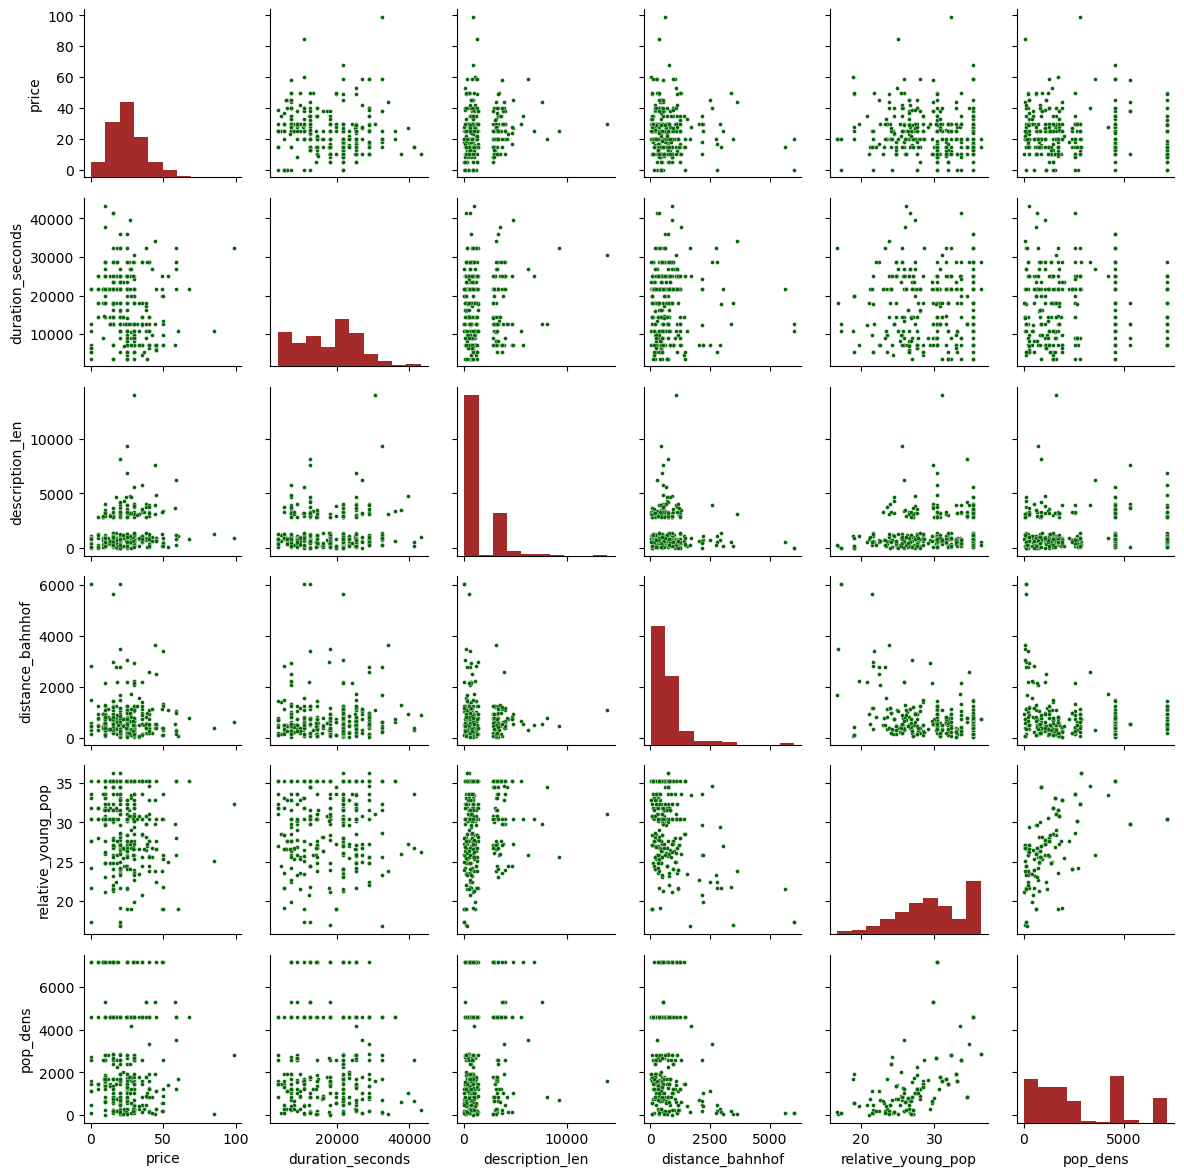

In [9]:
g2 = sns.PairGrid(df[['price', 'duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']], 
                 height=2, 
                 aspect=1)
g2.map_upper(sns.scatterplot,color='darkgreen', s=8)
g2.map_lower(sns.scatterplot, color='darkgreen', s=8)
g2.map_diag(plt.hist, color='brown')
plt.show()

## Generate Scatterplot and calculate p-values and slope

p-value of duration_seconds: 0.0102
p-value one sided of duration_seconds: 0.0051
slope of duration_seconds: -0.0002
 
p-value of description_len: 0.0057
p-value one sided of description_len: 0.0029
slope of description_len: 0.0012
 
p-value of distance_bahnhof: 0.2934
p-value one sided of distance_bahnhof: 0.1467
slope of distance_bahnhof: -0.0010
 
p-value of relative_young_pop: 0.1745
p-value one sided of relative_young_pop: 0.0873
slope of relative_young_pop: -0.2056
 
p-value of pop_dens: 0.1709
p-value one sided of pop_dens: 0.0854
slope of pop_dens: -0.0004
 


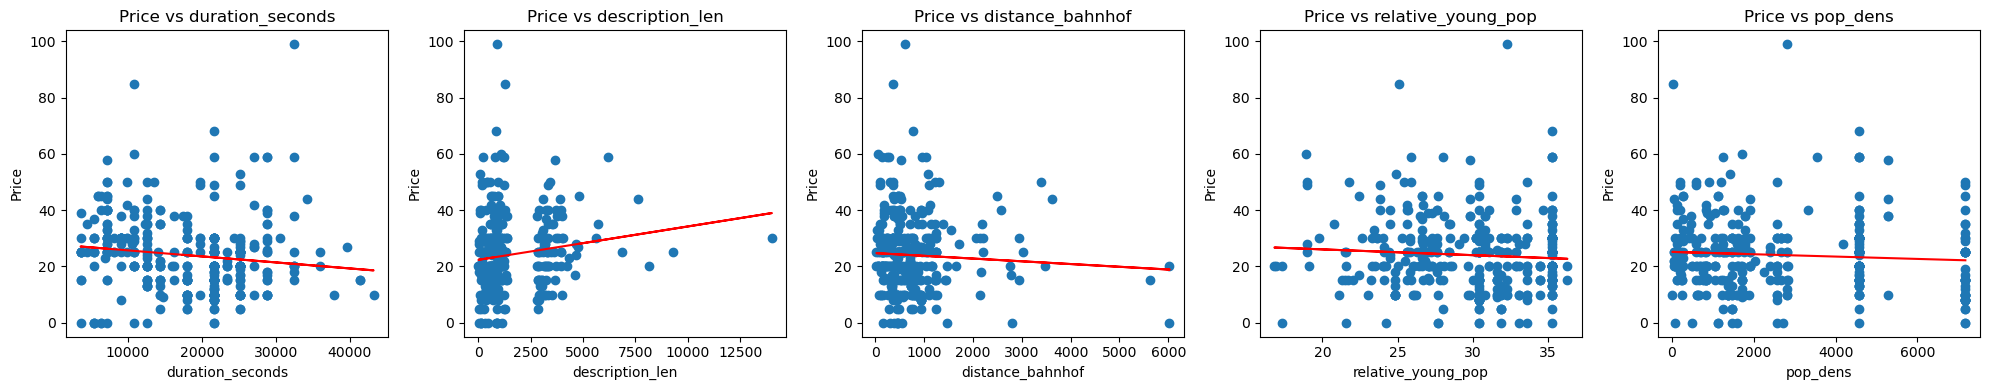

In [11]:
variables = ['duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']

plt.figure(figsize=(20, 4))  # Adjust the figure size as needed

for i, var in enumerate(variables):
    plt.subplot(1, 5, i + 1)  # 1 row, 5 columns, ith plot
    
    # Scatter plot
    plt.scatter(df[var], df['price'])

    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[var], df['price'])
    # Create a line based on the slope and intercept
    line = slope * df[var] + intercept
    plt.plot(df[var], line, color='red')  # Add the line to the plot
    
    one_sided_p_value = p_value / 2
    
    print("p-value of " + var + ": " + str(format(p_value, '.4f')))
    print("p-value one sided of " + var + ": " + str(format(one_sided_p_value, '.4f')))
    print("slope of " + var + ": " + str(format(slope, '.4f')))
    print(" ")

    # Labeling the plot
    plt.title(f'Price vs {var}')
    plt.xlabel(var)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

## Multiple linear regression

In [16]:
X = df[['duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating a linear regression model
model = linear_model.LinearRegression()

# Fitting the model
model.fit(X_train.values, y_train.values)

# Predicting the Test set results
y_pred = model.predict(X_test.values)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 137.99820893539575


In [17]:
# Add constant to the model
X_train_const = sm.add_constant(X_train)

# Create the multiple regression model
olsmod = sm.OLS(y_train, X_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.441
Date:                Sat, 13 Jan 2024   Prob (F-statistic):             0.0346
Time:                        14:12:58   Log-Likelihood:                -1185.9
No. Observations:                 297   AIC:                             2384.
Df Residuals:                     291   BIC:                             2406.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 33.2781      6

## Random Forest

In [19]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=5, 
                               random_state=5)
reg_rf.fit(X_train.values, y_train.values)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X_test.values, y_test.values).round(4))

R-squared: 0.2501


## Show feature importance

Index(['description_len', 'distance_bahnhof', 'duration_seconds',
       'relative_young_pop', 'pop_dens'],
      dtype='object')
[0.28095395 0.2331153  0.19318163 0.1478664  0.14488272]


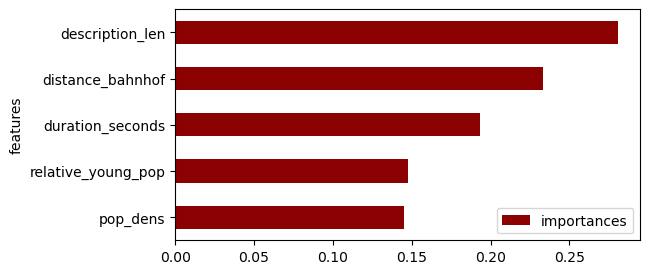

In [20]:
cols = X_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()

## Pearsons correlation

In [21]:
# Perform Persons correlation
res = stats.pearsonr(df['price'], df['duration_seconds'])

# Print result
print(f'Persons correlation coefficient (r): {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

Persons correlation coefficient (r): -0.1330
p-value: 0.0102


The p-value is lower than 0.05 therefore the variables price and duration are significantly correlated. H0 can be rejected.

## T-Test

In [23]:
df_party = df.loc[df['is_concert'] == 0]
df_concert = df.loc[df['is_concert'] == 1]

result = stats.ttest_ind(df_party['price'], 
                         df_concert['price'])

print('Test-statistic:', result[0].round(5), 'p-value',  result[1].round(5))

Test-statistic: -5.09843 p-value 0.0


## ANOVA Test - price

In [24]:
fvalue, pvalue = stats.f_oneway(df_party['price'], df_concert['price'])

# Print results
print('F-value:', fvalue.round(3), 'p-value', pvalue.round(5))
# print("ANOVA Result (F-statistic and P-value):", result)

F-value: 25.994 p-value 0.0


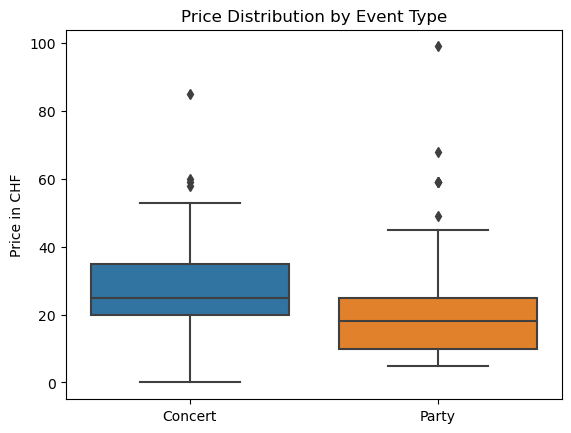

In [25]:
sns.boxplot(x='is_concert', y='price', data=df, order=[True, False])
plt.title('Price Distribution by Event Type')
plt.ylabel('Price in CHF')
plt.xlabel('')
plt.xticks([0, 1], ['Concert', 'Party'], rotation=0) 
plt.show()

## ANOVA Test - Duration

In [26]:
fvalue, pvalue = stats.f_oneway(df_party['duration_seconds'], df_concert['duration_seconds'])

# Print results
print('F-value:', fvalue.round(3), 'p-value', pvalue.round(5))
# print("ANOVA Result (F-statistic and P-value):", result)

F-value: 264.766 p-value 0.0


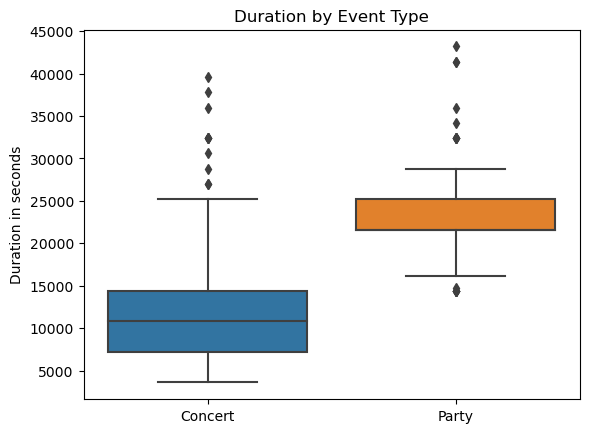

In [27]:
sns.boxplot(x='is_concert', y='duration_seconds', data=df, order=[True, False])
plt.title('Duration by Event Type')
plt.ylabel('Duration in seconds')
plt.xlabel('')
plt.xticks([0, 1], ['Concert', 'Party'], rotation=0) 
plt.show()

### Jupyter notebook --footer info--

In [94]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 23.2.0
Datetime: 2023-12-23 01:15:02
Python Version: 3.9.13
-----------------------------------
